In [4]:
pathToModels = "D:\\models\\python\\"
pathToTests = "C:\\Users\\Mcall\\Desktop\\Sca-ML\\sca-ml\\Jupyter Notebooks\\Testing\\Testing Set\\"
"""Startup"""
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import re
import numpy as np
import pickle
from IPython.display import clear_output
import time
from tokenize import TokenInfo
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers import Conv2D
import json



slashForDir = "\\"
def convSlashes(path):
    return path.replace("/", slashForDir).replace("\\", slashForDir)


# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
        
def searchFiles(path, fileformats):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            for fileformat in fileformats:
                if file.endswith(fileformat):
                    #code to generate a list of paths of files to generate logs for
                    filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo

def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                #code to generate a list of paths of files to generate logs for
                filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo





In [2]:
"Text Processing"
"Up to date with model creation since 11/25/22"


regexBlankLineMostly = r"(^\s{1,}$)"
regexBlankLineFinish = r"(^\n{1,})"

def stringProcessing(string):
    string = string.replace("\"\"\"" , "\"")
    string = string.replace("\'\'\'" , "\"")
    string = string.replace("\\'" , "")
    string = string.replace('\\"' , "")
    string = re.sub("('|\")[\x1f-\x7e]{1,}?('|\")", " \"sGH\"", string)
    string = re.sub("#.*", "", string)
    string = string.replace('    ', '\t')
    string = re.sub(regexBlankLineMostly, '', string, 0, re.MULTILINE)
    string = re.sub(regexBlankLineFinish, '', string, 0, re.MULTILINE)
    return string


to_pad = ['\n', '\t', '\r', '(', ')', '[', ']', '{', '}', '<', '>', '!', '?', ',', '.', ':', ';', '`', '~', '@', '#', '$', '%', '^', '&', '*', '=', '+', '/', '\\', '|']

def stringPadding(dataSet):
    if (type(dataSet) == str):
        for i in range(len(to_pad)):
            dataSet = dataSet.replace(to_pad[i], ' ' + to_pad[i] + ' ')
        return dataSet

In [6]:
#load 1 model
modelName = "python_model_1_IMPROVED"

model = load_model(pathToModels + modelName + slashForDir + 'model.h5')

model.summary()
import pickle
with open(pathToModels + modelName + slashForDir + 'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open(pathToModels + modelName + slashForDir + 'modelInfo.json') as json_file:
    modelInfo = json.load(json_file)
    modelInfo = {**modelInfo, **{"modelName": modelName}}


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 2000)       2002000   
                                                                 
 conv1d (Conv1D)             (None, 9997, 256)         2048256   
                                                                 
 conv1d_1 (Conv1D)           (None, 9994, 256)         262400    
                                                                 
 flatten (Flatten)           (None, 2558464)           0         
                                                                 
 dense (Dense)               (None, 128)               327483520 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 331,796,305
Trainable params: 331,796,305


In [4]:
"load Array of models"
modelNames = ["python_model_1_RNN", "python_model_1_IMPROVED"]
models = []
tokenizers = []
modelInfos = []
for modelName in modelNames:
    model = load_model(pathToModels + modelName + '/model.h5')
    models.append(model)
    with open(pathToModels + modelName + '/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
        tokenizers.append(tokenizer)
    with open(pathToModels + modelName + '/modelInfo.json') as json_file:
        modelInfo = json.load(json_file)
        #add the model name
        modelInfo = {**modelInfo, **{"modelName": modelName}}
        modelInfos.append(modelInfo)

2022-11-28 14:23:07.449666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 14:23:07.449923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 14:23:07.450135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 14:23:07.452192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 14:23:07.452366: I tensorflow/compile

: 

: 

In [23]:
"Test Models"

"""Folder definition for Model Testing:
FOLDER:
testInfo.json (Contains the type of test and information for each file. See below)
testCode
"""

"""Types of test: 
Pos Linear comparative (PosLinCar): Each sequential file is expected to score higher than the last. Files are named 0.txt, 1.txt, 2.txt, etc.
Neutral (Neutral): Each file is expected to score about the same. Files are named 0.txt, 1.txt, 2.txt, etc.

"""



def modelTesting(modell, tokenizerl, modelInfol, testFolder): 
    with open(testFolder + slashForDir + 'testInfo.json') as json_file:
        testInfo = json.load(json_file)
    #Check if model is an array of models
    if (type(modell) == list):
        for i in range(len(modell)):
            modelTestingRunner(modell[i], tokenizerl[i], modelInfol[i], testFolder, testInfo)
    else:
        modelTestingRunner(modell, tokenizerl, modelInfol, testFolder, testInfo)
        
def modelTestingRunner(modell, tokenizerl, modelInfol, testFolder, testInfo):
    print ("Testing " + modelInfol["modelName"])
    if testInfo['type'] == 'LinCar':
        posLinCarTest(modell, tokenizerl, modelInfol, testFolder)
    if testInfo['type'] == 'Neutral':
        neutralTest(modell, tokenizerl, modelInfol, testFolder)
    #Check if model is an array of models

    
def posLinCarTest(modell, tokenizerl, modelInfo1, testFolder):
    #load testInfo.json
    scores = []
    #load testCode
    filesToLoad = searchFiles(testFolder, ['.py'])
    for file in filesToLoad:
        with open(testFolder + file) as f:
            code = f.read()
            code = stringProcessing(code)
            code = stringPadding(code)
            code = tokenizerl.texts_to_sequences([code])
            code = pad_sequences(code, maxlen=modelInfo1['maxLen'])
            score = modell.predict(code)
            scores = np.append(scores, score)
            
    scoresDelta = []
    for i in range(len(scores) - 1):
        scoresDelta = np.append(scoresDelta, scores[i + 1] - scores[i])
    print (scores)
    print (scoresDelta)
    print ("expected outcome, scores should go up as the files go up, scoresDeltas should be positive")
    #graph scores in a scatter plot 
    plt.scatter(range(len(scores)), scores, label=modelInfo1['modelName'])
    plt.legend()
    plt.show()
    plt.scatter(range(len(scoresDelta)), scoresDelta, label=modelInfo1['modelName']+ " Delta")
    plt.legend()
    plt.show()

    
def neutralTest(modell, tokenizerl, modelInfo1, testFolder):
    scores = []
    #load testCode
    filesToLoad = searchFiles(testFolder, ['.py'])
#sort the files
    for file in range(len(filesToLoad)):
        with open(testFolder + slashForDir + str(file) + ".py") as f:
            code = f.read()
            code = stringProcessing(code)
            code = stringPadding(code)
            code = tokenizerl.texts_to_sequences([code])
            code = pad_sequences(code, maxlen=modelInfo1['maxLen'])
            score = modell.predict(code)
            scores = np.append(scores, score)
            
            
    scoresDelta = []
    coreavg = np.average(scores)
    scoreMedian = np.median(scores)

    for i in range(len(scores) - 1):
        scoresDelta = np.append(scoresDelta, scores[i] - coreavg)
    for i in range(len(scores) - 1):
        scoresDeltaMed = np.append(scoresDelta, scores[i] - scoreMedian)
    print (scores)
    print (scoresDelta)
    print (scoresDeltaMed)
    print ("Biggest Score AVG Delta: " + str(max(scoresDelta)))
    print ("expected outcome, scores should be about the same, scoresDeltas should be about the same")
    #graph scores in a scatter plot, label the score the model name
    plt.scatter(range(len(scores)), scores, label=modelInfo1['modelName'])
    plt.legend()
    plt.grid()
    plt.show()
    plt.scatter(range(len(scoresDelta)), scoresDelta, label=modelInfo1['modelName']+ " Delta")
    plt.legend()
    plt.grid()
    plt.show()
    plt.scatter(range(len(scoresDeltaMed)), scoresDeltaMed, label=modelInfo1['modelName']+ " Delta Med")
    plt.legend()
    plt.grid()
    plt.show()
    

    

{'maxWords': 1000, 'maxLen': 10000, 'modelName': 'python_model_1_IMPROVED'}
Testing python_model_1_IMPROVED
1/1 [==============================] - 0s 236ms/step
[25.05365372 25.05365372 25.24101067 23.42605209 25.1970005  25.1970005
 24.22421265 24.50727844 25.06851387 25.06851387 25.06851387 25.18499756
 41.69329453 23.49991989 23.49991989 23.49991989 41.69329453 23.49991989
 41.69329453 41.69329453 41.69329453 23.49991989 23.49991989 41.69329453
 26.79335213 23.49991989 26.34170914 29.81060219 24.64942169 25.19641876
 24.94651794]
[-3.03304402 -3.03304402 -2.84568707 -4.66064564 -2.88969723 -2.88969723
 -3.86248509 -3.57941929 -3.01818386 -3.01818386 -3.01818386 -2.90170017
 13.60659679 -4.58677784 -4.58677784 -4.58677784 13.60659679 -4.58677784
 13.60659679 13.60659679 13.60659679 -4.58677784 -4.58677784 13.60659679
 -1.29334561 -4.58677784 -1.7449886   1.72390446 -3.43727604 -2.89027897]
[-3.03304402 -3.03304402 -2.84568707 -4.66064564 -2.88969723 -2.88969723
 -3.86248509 -3.579419

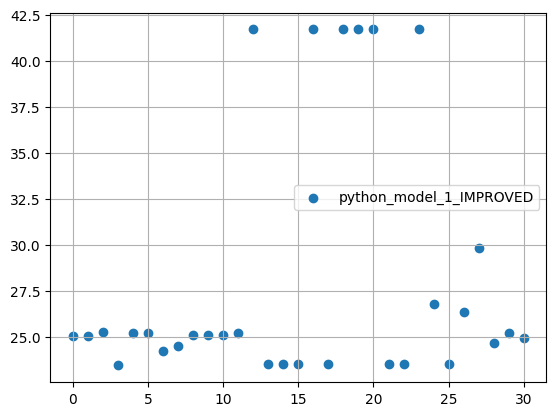

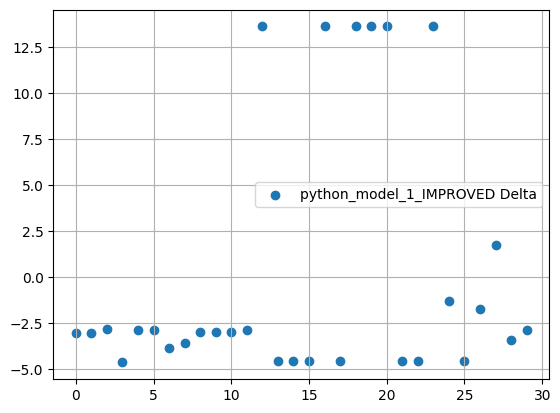

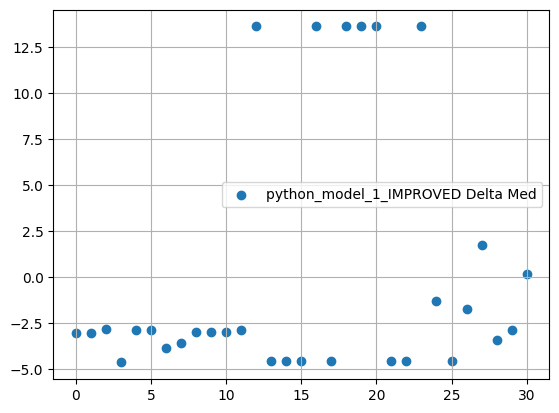

In [50]:
"temp testing stuff"
print (modelInfo)



modelTesting(model, tokenizer, modelInfo, pathToTests + 'ASS-OCC')



In [2]:
import tensorflow
#test to make sure gpu is detected
tensorflow.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-11-28 14:12:38.567587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 14:12:38.709773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 14:12:38.736127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 14:12:38.736365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

True